# Bayesian Networks

**Colaborators:** Andrej Betík (456604), Robin Knaur (409844), Jiří Novotný (409963)

In [1]:
# Packages Installation 
install_pckgs_if_not_installed <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}
pckgs <- c("tidyr", "ggplot2", "caret", "gridExtra", "ROSE", "bartMachine", "splitstackshape", "caret", "arm")
suppressWarnings(install_pckgs_if_not_installed(pckgs))

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: caret
Loading required package: lattice
Loading required package: gridExtra
Loading required package: ROSE
Loaded ROSE 0.0-3

Loading required package: bartMachine
Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach
Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 0.48GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM before you call
'library(bartMachine)'.



tidyr         ggplot2           caret       gridExtra            ROSE 
           TRUE            TRUE            TRUE            TRUE            TRUE 
    bartMachine splitstackshape           caret             arm 
           TRUE            TRUE            TRUE            TRUE

## 1. Introduction

### We have chosen these three methods
 - Bayesian Generalized Linear Model (Robin Knaur)
 - Bayesian Additive Regression Trees (Andrej Betík)
 - Bayesian Ridge Regression (Jiří Novotný)
 
 ### And we have these three datasets
 - Bank dataset (Robin Knaur)
 - German Credit Data (Andrej Betík)
 - Energy efficiency (Jiří Novotný)
 

## 2. Exploratory Analysis

### Bank dataset
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

#### Attribute Information:

##### Input variables:
###### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
###### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
###### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
###### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

###### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')




In [26]:
#load datasets
bank_train <- read.csv("datasets/bank-additional.csv", sep=";")
bank_test <- read.csv("datasets/bank-additional-full.csv", sep=";")

head(bank_train)

age,job,marital,education,default,housing,loan,contact,month,day_of_week,⋯,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,⋯,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
39,services,single,high.school,no,no,no,telephone,may,fri,⋯,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
25,services,married,high.school,no,yes,no,telephone,jun,wed,⋯,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,⋯,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,⋯,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
32,services,single,university.degree,no,no,no,cellular,sep,thu,⋯,3,999,2,failure,-1.1,94.199,-37.5,0.884,4963.6,no


In [27]:
# number of samples
nrow(bank_train)
nrow(bank_test)

[1] 4119

[1] 41188

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

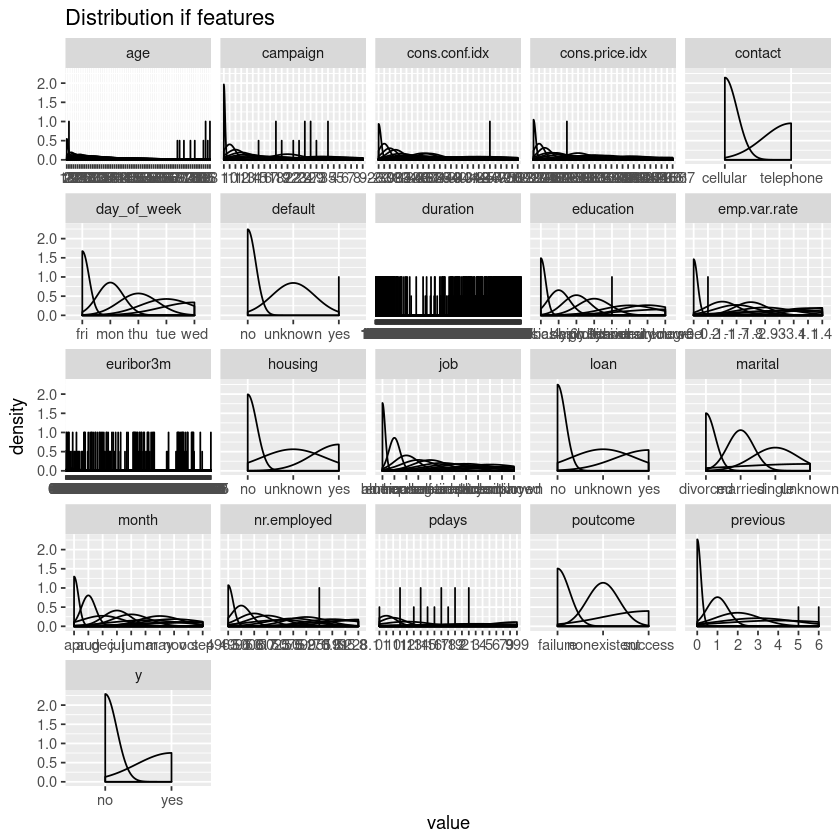

In [28]:
library(tidyr)
library(ggplot2)

# look at distribution of values for each feature
ggplot(gather(bank_train), aes(value)) +
    geom_density() +
    facet_wrap(~key, scales = 'free_x') +
    ggtitle("Distribution if features")

### German Credit Data
The original dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes.
I have ignored some columns, because either they are not important or their descriptions are obscure. The original dataset can be found at https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

#### Attribute Information:
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
###### Output variable (desired target)
10. Risk (Value target - Good or Bad Risk)

### Visualization

In [2]:
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(gridExtra)))
german_credit <- read.csv("datasets/german_credit.csv")
str(german_credit)

'data.frame':	1000 obs. of  10 variables:
 $ Age             : int  67 22 49 45 53 35 53 35 61 28 ...
 $ Sex             : Factor w/ 2 levels "female","male": 2 1 2 2 2 2 2 2 2 2 ...
 $ Job             : int  2 2 1 2 2 1 2 3 1 3 ...
 $ Housing         : Factor w/ 3 levels "free","own","rent": 2 2 2 1 1 1 2 3 2 2 ...
 $ Saving.accounts : Factor w/ 4 levels "little","moderate",..: NA 1 1 1 1 NA 3 1 4 1 ...
 $ Checking.account: Factor w/ 3 levels "little","moderate",..: 1 2 NA 1 1 NA NA 2 NA 2 ...
 $ Credit.amount   : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ Duration        : int  6 48 12 42 24 36 24 36 12 30 ...
 $ Purpose         : Factor w/ 8 levels "business","car",..: 6 6 4 5 2 4 5 2 6 2 ...
 $ Risk            : Factor w/ 2 levels "bad","good": 2 1 2 2 1 2 2 2 2 1 ...


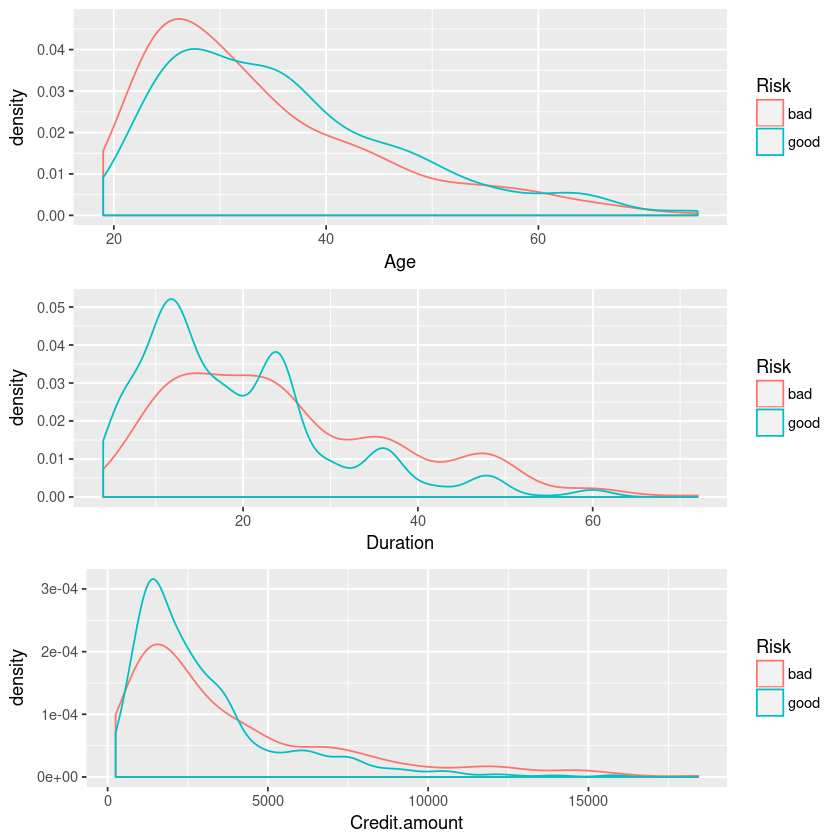

In [3]:
# Inspection of some interesting data features

# People at very young age seem to have worse credit worthiness
p1 <- ggplot(german_credit, aes(x=Age, color=Risk)) + geom_density()
# Surprisingly there's not really a trend of "Longer duration better credit worthiness"
p2 <- ggplot(german_credit, aes(x=Duration, color=Risk)) + geom_density()
# A trend of "Higher credit amount, better credit worthiness"
p3 <- ggplot(german_credit, aes(x=Credit.amount, color=Risk)) + geom_density()
grid.arrange(p1, p2, p3)

### Energy efficiency
* Authors: Angeliki Xifara, Athanasios Tsanas
* Link: https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

#### Abstract
Authors performed energy analysis using 12 different building shapes simulated in Ecotect. The buildings differed with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. They simulated various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

#### Attributes
* X1 Relative Compactness
* X2 Surface Area
* X3 Wall Area
* X4 Roof Area
* X5 Overall Height
* X6 Orientation
* X7 Glazing Area
* X8 Glazing Area Distribution
* y1 Heating Load
* y2 Cooling Load

In [4]:
#load csv
energy <- read.csv("datasets/energy_efficency.csv")

#rename columns
names(energy) <- c("relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height",
                   "orientation", "glazing_area", "glazing_area_distribution", "heating_load", "cooling_load")
head(energy)

relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0.98,514.5,294.0,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,4,0,0,15.55,21.33
0.98,514.5,294.0,110.25,7,5,0,0,15.55,21.33
0.90,563.5,318.5,122.50,7,2,0,0,20.84,28.28
0.90,563.5,318.5,122.50,7,3,0,0,21.46,25.38


In [5]:
# number of samples
nrow(energy)

[1] 768

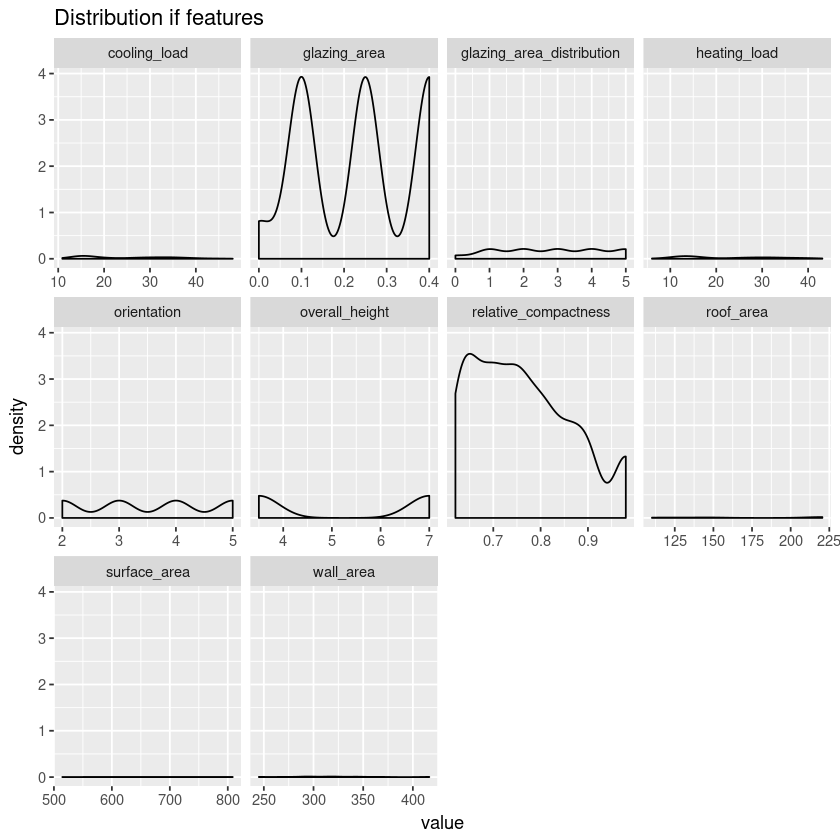

In [6]:
library(tidyr)
library(ggplot2)

# look at distribution of values for each feature
ggplot(gather(energy), aes(value)) +
    geom_density() +
    facet_wrap(~key, scales = 'free_x') +
    ggtitle("Distribution if features")

## 3. Preprocessing

### Bank dataset

This dataset could be used without any preprocessing, but it still be usefull to do some.

First remove the duration column, becase it represents length of a phone call which couldn't be known before phonecall itself and strongly correlate with output variable.

Since it's a telemarketing, majority of people refused an offer, so the distribution of classes is unbalanced. I decided to use oversampling to deal with this issue. If I wouldn't use it, sensitivity would be very low.


In [7]:
library('caret')
library('arm')

#remove duration column
bank_train_without_duration <- subset(bank_train, select = -c(duration))
bank_test_without_duration <- subset(bank_test, select = -c(duration))

# oversampling
library(splitstackshape)

yes_rows = subset(bank_train, y == 'yes')
multiplied_yes_rows = expandRows(yes_rows, 8, count.is.col = FALSE, drop = FALSE)
oversampled_bank_train = rbind(bank_train, multiplied_yes_rows)

### German Credit Data
#### Preprocessing consits of :
##### 1)  Handling of Missing Data
##### 2) Ballancing the data

In [8]:
# Checking for missing values
sum(is.na(german_credit))

[1] 577

In [9]:
# But all of them are in attributes Saving.accounts and Checking.accounts which are categorical values
sum(is.na(german_credit$Checking.account)) + sum(is.na(german_credit$Saving.accounts))

[1] 577

In [10]:
# To get rid of missing values I replace <NA> samples with a new level "Unknown"
levels(german_credit$Saving.accounts) = c(levels(german_credit$Saving.accounts), "Unknown")
german_credit$Saving.accounts[which(is.na(german_credit$Saving.accounts))] = "Unknown"
levels(german_credit$Checking.account) = c(levels(german_credit$Checking.account), "Unknown")
german_credit$Checking.account[which(is.na(german_credit$Checking.account))] = "Unknown"

In [11]:
any(is.na(german_credit))

[1] FALSE

In [12]:
# Apparantly this dataset is unballanced(has unequal instances for different classes)
table(german_credit$Risk)


 bad good 
 300  700 

In [13]:
# Using function ovun.sample to ballance the data
# It creates possibly balanced samples by combination of random over-sampling minority examples and under-sampling
# majority examples.
# Over/Under sampling whole dataset would create copies of the same point.
# It may end up in both the training and test sets. This allows the classifier to cheat.
# Firstly I will divide the dataset to train/test and over/under sample just the train one.
set.seed(123)
trainIndex <- createDataPartition(german_credit$Risk, .7, list=FALSE, times = 1)
german_credit_train <- german_credit[trainIndex,]
german_credit_test <- german_credit[-trainIndex,]

In [14]:
# Before the over/under sampling
table(german_credit_train$Risk)


 bad good 
 210  490 

In [15]:
suppressPackageStartupMessages(suppressWarnings(library(ROSE)))
german_credit_train <- ovun.sample(Risk~., data=german_credit_train,
                                   N=nrow(german_credit_train), p=0.5, 
                                   seed=1, method="both")$data
# After the over/under sampling
table(german_credit_train$Risk)


good  bad 
 360  340 

### Energy efficiency

In [16]:
# Contains any NA values?
any(is.na(energy))

[1] FALSE

In [17]:
# define my version of summary method with standard deviation included
energy_summary <- function(df) {
    data.frame(mean=sapply(df, mean),
               std=sapply(df, sd),
               min=sapply(df, min),
               q_0.25=sapply(df, function(col) quantile(col, probs=0.25)),
               q_0.50=sapply(df, function(col) quantile(col, probs=0.50)),
               q_0.75=sapply(df, function(col) quantile(col, probs=0.75)),
               max=sapply(df, max))
}

# check the means and standard deviations for each feature
energy_summary(energy)

,mean,std,min,q_0.25,q_0.50,q_0.75,max
relative_compactness,0.7641667,0.1057775,0.62,0.6825,0.75,0.8300,0.98
surface_area,671.7083333,88.0861161,514.50,606.3750,673.75,741.1250,808.50
wall_area,318.5000000,43.6264814,245.00,294.0000,318.50,343.0000,416.50
roof_area,176.6041667,45.1659502,110.25,140.8750,183.75,220.5000,220.50
overall_height,5.2500000,1.7511404,3.50,3.5000,5.25,7.0000,7.00
orientation,3.5000000,1.1187626,2.00,2.7500,3.50,4.2500,5.00
glazing_area,0.2343750,0.1332206,0.00,0.1000,0.25,0.4000,0.40
glazing_area_distribution,2.8125000,1.5509597,0.00,1.7500,3.00,4.0000,5.00
heating_load,22.3071953,10.0902040,6.01,12.9925,18.95,31.6675,43.10
cooling_load,24.5877604,9.5133056,10.90,15.6200,22.08,33.1325,48.03


In [18]:
# normalize each feature (transform them to have mean=0 and std=1) - leave out the dependant variables
energy_feat <- energy[, !(names(energy) %in% c("heating_load", "cooling_load"))]
energy_feat <- as.data.frame(scale(energy_feat))
energy_feat$heating_load <- energy$heating_load
energy_feat$cooling_load <- energy$cooling_load
energy <- energy_feat
rm(energy_feat)

# recheck the means and stadard deviations
energy_summary(energy)

,mean,std,min,q_0.25,q_0.50,q_0.75,max
relative_compactness,-7.914394e-18,1.000000,-1.3629241,-0.7720610,-0.13392895,0.6223757,2.0404470
surface_area,-4.431493e-16,1.000000,-1.7847118,-0.7416984,0.02317808,0.7880546,1.5529311
wall_area,0.000000e+00,1.000000,-1.6847565,-0.5615855,0.00000000,0.5615855,2.2463421
roof_area,2.036136e-16,1.000000,-1.4691192,-0.7910642,0.15821284,0.9718789,0.9718789
overall_height,0.000000e+00,1.000000,-0.9993487,-0.9993487,0.00000000,0.9993487,0.9993487
orientation,0.000000e+00,1.000000,-1.3407670,-0.6703835,0.00000000,0.6703835,1.3407670
glazing_area,1.158831e-16,1.000000,-1.7593005,-1.0086656,0.11728670,1.2432390,1.2432390
glazing_area_distribution,1.053257e-17,1.000000,-1.8133934,-0.6850597,0.12089289,0.7656550,1.4104171
heating_load,2.230720e+01,10.090204,6.0100000,12.9925000,18.95000000,31.6675000,43.1000000
cooling_load,2.458776e+01,9.513306,10.9000000,15.6200000,22.08000000,33.1325000,48.0300000


## 4. Learning Algorithms

### Bayesian Generalized Linear Model

#### Bank dataset

In [19]:
bglm_bank_model <- train(y ~ ., data = oversampled_bank_train, method = 'bayesglm')

bglm_bank_prediction <- predict(bglm_bank_model, newdata = bank_test)
confusionMatrix(bglm_bank_prediction, bank_test$y, positive="yes")

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  31502   574
       yes  5046  4066
                                          
               Accuracy : 0.8636          
                 95% CI : (0.8602, 0.8669)
    No Information Rate : 0.8873          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.5196          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.87629         
            Specificity : 0.86193         
         Pos Pred Value : 0.44622         
         Neg Pred Value : 0.98211         
             Prevalence : 0.11265         
         Detection Rate : 0.09872         
   Detection Prevalence : 0.22123         
      Balanced Accuracy : 0.86911         
                                          
       'Positive' Class : yes             
                                          

#### German credit Data

In [20]:
bglm_credit_model <- train(Risk ~ ., data = german_credit[trainIndex,], method = 'bayesglm')


bglm_credit_prediction <- predict(bglm_credit_model, german_credit[-trainIndex,])
confusionMatrix(bglm_credit_prediction, german_credit[-trainIndex,]$Risk)

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   38   45
      good  52  165
                                          
               Accuracy : 0.6767          
                 95% CI : (0.6205, 0.7293)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : 0.8279          
                                          
                  Kappa : 0.2127          
 Mcnemar's Test P-Value : 0.5424          
                                          
            Sensitivity : 0.4222          
            Specificity : 0.7857          
         Pos Pred Value : 0.4578          
         Neg Pred Value : 0.7604          
             Prevalence : 0.3000          
         Detection Rate : 0.1267          
   Detection Prevalence : 0.2767          
      Balanced Accuracy : 0.6040          
                                          
       'Positive' Class : bad             
                                          

#### Energy efficiency

In [21]:
# insert some code here

### Bayesian Additive Regression Trees

#### Fitting German Credit Data

In [22]:
# Setting computing parameters for BartMachine. 4 GB RAM for Java heap and number of computing cores set to 4.
suppressPackageStartupMessages(suppressWarnings(options(java.parameters = "-Xmx4g")))
suppressPackageStartupMessages(suppressWarnings(set_bart_machine_num_cores(4)))

bartMachine now using 4 cores.


In [23]:
bartTrainControl <- trainControl(method = "cv",  number=3, verboseIter=FALSE)
bartmachine_fit <- suppressWarnings(train(Risk ~ ., 
                                          data = german_credit_train, 
                                          method ="bartMachine",
                                          trControl = bartTrainControl,
                                          metric = 'Accuracy',
                                          verbose = FALSE))

In [24]:
bartMachine_predict <- predict(bartmachine_fit, german_credit_test, verbose = FALSE)
confusionMatrix(bartMachine_predict, german_credit_test$Risk)

Warning message in confusionMatrix.default(bartMachine_predict, german_credit_test$Risk):
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction bad good
      bad   63   72
      good  27  138
                                         
               Accuracy : 0.67           
                 95% CI : (0.6136, 0.723)
    No Information Rate : 0.7            
    P-Value [Acc > NIR] : 0.8837         
                                         
                  Kappa : 0.3125         
 Mcnemar's Test P-Value : 9.772e-06      
                                         
            Sensitivity : 0.7000         
            Specificity : 0.6571         
         Pos Pred Value : 0.4667         
         Neg Pred Value : 0.8364         
             Prevalence : 0.3000         
         Detection Rate : 0.2100         
   Detection Prevalence : 0.4500         
      Balanced Accuracy : 0.6786         
                                         
       'Positive' Class : bad            
                                         

## 5. Evaluation

## 6. Conclusion

## 7. References

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing